# First 6hr Sun observation analysis

In [1]:
import ugradio
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.table as Table
from datetime import datetime
from datetime import timedelta
import time
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import mpl_toolkits.axes_grid1 as axgrid
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy

%matplotlib inline
plt.rcParams['mathtext.fontset'], plt.rcParams['font.family'] = 'stix', 'STIXGeneral'
plt.rcParams.update({'font.size': 17})

No module named 'rtlsdr'


## Loading in the data

Data was collected on March 22, 2022 beginning at 8:27:25 am and ending on 2:26:52 pm (PST).

In [300]:
volts, times = np.load('Data/6hr_Sun_data.npy')

### Getting the times of observation in PST and JD:

In [301]:
beginning_time = min(times)
ending_time = max(times)

beginning_local_time = ugradio.timing.local_time(beginning_time)
ending_local_time = ugradio.timing.local_time(ending_time)

beginning_jd = ugradio.timing.julian_date(beginning_time)
ending_jd = ugradio.timing.julian_date(ending_time)


print('Beginning time in local time (PST):', beginning_local_time, '\nEnding time in local time (PST):', ending_local_time)

print('\nBeginning JD:', beginning_jd, '\nEnding JD:', ending_jd)

# beginning_local_time[11:19]

Beginning time in local time (PST): Tue Mar 22 08:27:25 2022 
Ending time in local time (PST): Tue Mar 22 14:26:52 2022

Beginning JD: 2459661.14404817 
Ending JD: 2459661.3936627596


## Looking for Fringes

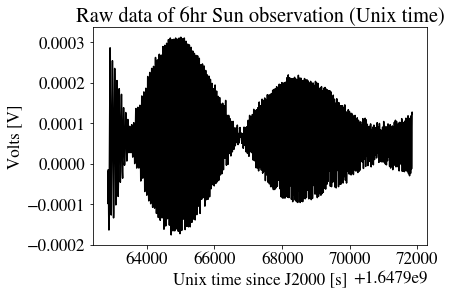

In [309]:
times = times[0:10000]
volts = volts[0:10000]

plt.figure()
plt.title('Raw data of 6hr Sun observation (Unix time)')
plt.plot(times, volts, 'k')
plt.xlabel('Unix time since J2000 [s]')
plt.ylabel('Volts [V]')
plt.show()

In [310]:
v_inter = np.median(np.diff(times))

freqs = np.fft.fftfreq(len(times), v_inter)

power = np.abs(np.fft.fft(volts))**2

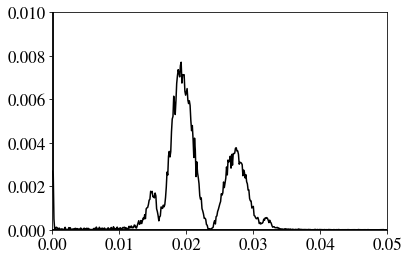

In [311]:
plt.figure()
plt.plot(freqs, power, 'k')
plt.xlim(0,0.05)
plt.ylim(0,0.01)
plt.show()

In [312]:
def pow_fft(arr):
    return np.fft.fftshift(np.abs(np.fft.fft(arr))**2)

def freq(arr, dt):
    return np.fft.fftshift(np.fft.fftfreq(len(arr), dt))


def split_data(data, time, num_splits):
    n = len(data)
    split_size = n // num_splits
    data_splits = []
    freq_splits = []
    for i in range(num_splits):
        data_frac = data[i*split_size:(i+1)*split_size]
        time_frac = time[i*split_size:(i+1)*split_size]
        dt = np.mean(np.diff(time_frac))
        frequency = freq(time_frac, dt)
        pow_frac = pow_fft(data_frac)
        
        data_splits.append(pow_frac)
        freq_splits.append(frequency)
        
    return data_splits, freq_splits

In [313]:
split_power, split_freqs = split_data(volts, times, 10)

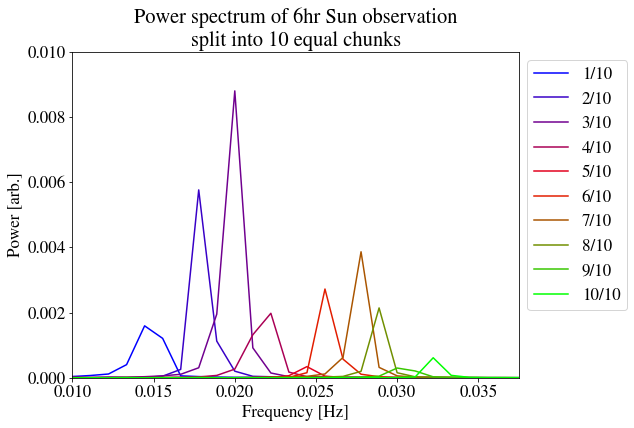

In [314]:
cmap = plt.cm.brg
n = len(split_power)
colors = cmap(np.linspace(0,1,n))


plt.figure(figsize=(8,6))
plt.title('Power spectrum of 6hr Sun observation\nsplit into {0:.0f} equal chunks'.format(len(split_power)))

labels = []
for i in range(len(split_power)):
    label = '{0:.0f}/{1:.0f}'.format(i+1, len(split_power))
    labels.append(label)

for i in range(len(split_power)):
    plt.plot(split_freqs[i], split_power[i], label=labels[i], color=colors[i])
    
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
# plt.yscale('log')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power [arb.]')
plt.xlim(0.01, 0.0375)
plt.ylim(0, 0.010)
plt.show()

### Expected fringe frequencies

In [315]:
def exp_fringe_freq(hs0, dec, Bew, Bns, L):
    λ = 2.5e-2 # m
    term1 = (Bew/λ)*np.cos(dec)*np.cos(hs0) 
    term2 = (Bns/λ)*np.sin(L)*np.cos(dec)*np.sin(hs0)
    ff = term1 -  term2
    return ff

In [316]:
Bew = 20  # m
Bns = 0

lat, lon = ugradio.nch.lat, ugradio.nch.lon # degrees
L = (np.pi/180)*lat # converting to radians

α, δ = ugradio.coord.sunpos(beginning_jd) # both calculated in degrees -- ra, dec calculated at beginning of observation
α = (np.pi/180)*α # converted to radians
δ = (np.pi/180)*δ # converted to radians
# ha = α*(24/(2*np.pi)) # convert ra to hour angle (hrs)

LST = ugradio.timing.lst(beginning_jd, lon) #radians
h_s = LST - α

print('Expected fringe frequency:', exp_fringe_freq(h_s, δ, Bew, Bns, L)) ## Hz??
## off by 1e-3??

Expected fringe frequency: 249.52838292556135


# Analysis

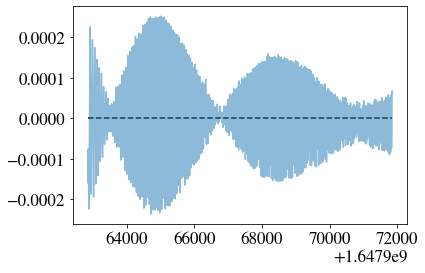

In [317]:
recentered_volts = volts - np.mean(volts)

plt.figure()
plt.plot(times, recentered_volts, alpha = 0.5)
plt.hlines(0, min(times), max(times), 'k', linestyle='--')
plt.show()

In [318]:
abs_centered_volts = abs(recentered_volts)

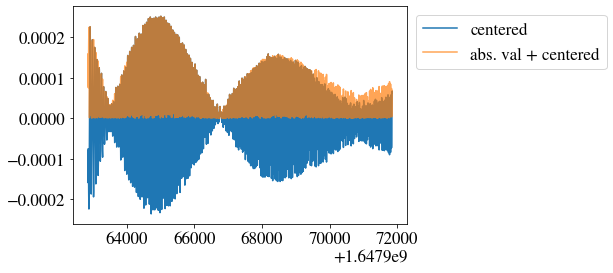

In [319]:
plt.figure()
plt.plot(times, recentered_volts, label='centered')
plt.plot(times, abs_centered_volts, alpha=0.7, label='abs. val + centered')
plt.legend(bbox_to_anchor=(1,1), loc='upper left')
plt.show()

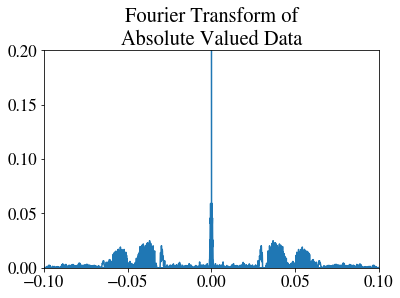

In [320]:
dt = np.mean(np.diff(times))

fft_volts = np.fft.fft(abs_centered_volts)
freqs = np.fft.fftfreq(len(times), dt)

plt.figure()
plt.title('Fourier Transform of\nAbsolute Valued Data')
plt.plot(freqs, fft_volts)
plt.ylim(0, 0.2)
plt.xlim(-0.1, 0.1)
plt.show()

In [321]:
fft_volts[np.where(freqs > 0.0025)] = 0
fft_volts[np.where(freqs < -0.0025)] = 0

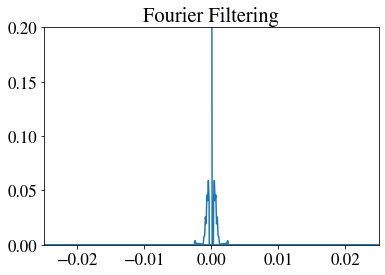

In [322]:
plt.figure()
plt.title('Fourier Filtering')
plt.plot(freqs, fft_volts)
plt.ylim(0,0.2)
plt.xlim(-0.025, 0.025)
plt.show()

(10000,)


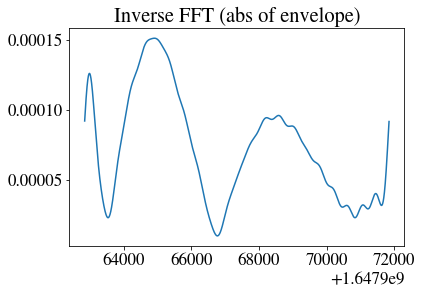

In [324]:
filtered_volts = np.fft.ifft(fft_volts)
print(filtered_volts.shape)

plt.figure()
plt.title('Inverse FFT (abs of envelope)')
plt.plot(times, filtered_volts)
plt.show()

In [325]:
abs_envelope = filtered_volts
abs_envelope.shape

(10000,)

In [326]:
jds = ugradio.timing.julian_date(times)
lsts = ugradio.timing.lst(jd=jds, lon=ugradio.coord.nch.lon)
α, δ = ugradio.coord.sunpos(beginning_jd) # both calculated in degrees -- ra, dec
α = (np.pi/180)*α # converted to radians
has = lsts - α

In [327]:
## Cutting more data:
has = has[75:9870]
recentered_volts = recentered_volts[75:9870]
abs_envelope = abs_envelope[75:9870]
times = times[75:9870]

has.shape, recentered_volts.shape, abs_envelope.shape, times.shape

((9795,), (9795,), (9795,), (9795,))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/collections.py:1342: ComplexWarning: Casting complex values to real discards the imaginary part
  seg = np.asarray(seg, float)


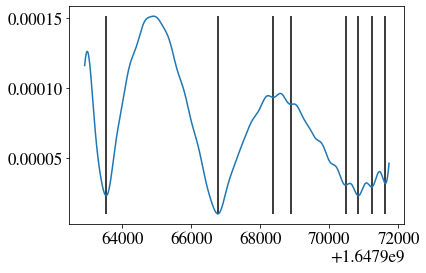

In [328]:
import scipy.signal as ss
local_minimum = ss.argrelmin(abs_envelope)
local_minimum = local_minimum[0]

plt.figure()
plt.plot(times, abs_envelope)
for i in range(len(local_minimum)):
    plt.vlines(times[local_minimum[i]], min(abs_envelope), max(abs_envelope))
plt.show()

# filtered_volts[local_minimum[0][0]]


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/collections.py:1342: ComplexWarning: Casting complex values to real discards the imaginary part
  seg = np.asarray(seg, float)


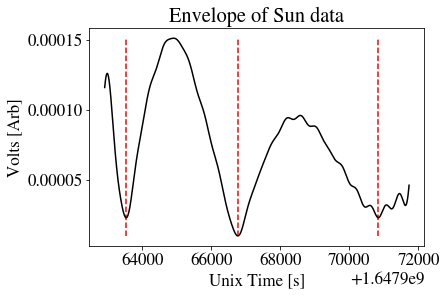

In [330]:
local_min = np.array([local_minimum[0], local_minimum[1], local_minimum[5]])

plt.figure()
plt.plot(times, abs_envelope, 'k')
for i in range(len(local_min)):
    plt.vlines(times[local_min[i]], min(abs_envelope), max(abs_envelope), color='red', linestyles='--')
plt.title('Envelope of Sun data')
plt.xlabel('Unix Time [s]')
plt.ylabel('Volts [Arb]')
plt.show()

In [335]:
chunk1 = abs_envelope[0:local_min[0]]
chunk1 = chunk1*-1
chunk2 = abs_envelope[local_min[0]:local_min[1]]
chunk3 = abs_envelope[local_min[1]:local_min[2]]
chunk3 = chunk3*-1
chunk4 = abs_envelope[local_min[2]:]
# chunk5 = abs_envelope[local_min[3]:]
# chunk5 = chunk5*-1

envelope = np.append(chunk1, chunk2)
envelope = np.append(envelope, chunk3)
envelope = np.append(envelope, chunk4)
# envelope = np.append(envelope, chunk5)

envelope.shape


(9795,)

In [336]:
envelope.shape, has.shape, abs_envelope.shape

((9795,), (9795,), (9795,))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1390: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


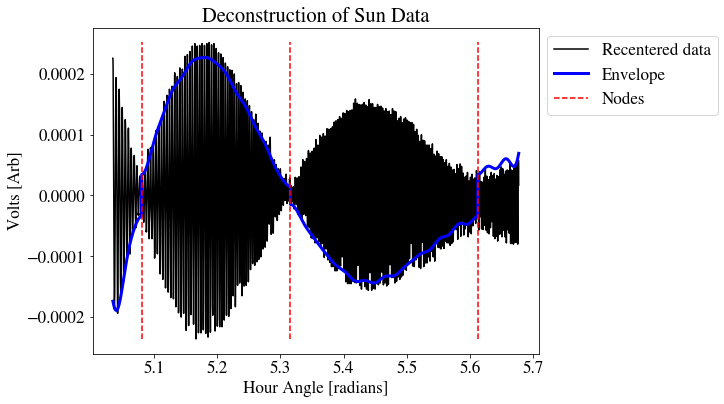

In [373]:
plt.figure(figsize=(8,6))
for i in range(len(local_min)):
    plt.vlines(has[local_min[i]], min(recentered_volts), max(recentered_volts), color='red', linestyles='--', zorder=6)
plt.plot(has, recentered_volts, 'k')
plt.plot(has, envelope*1.5, 'b', lw=3)
# plt.plot(has[0:9870], envelope[0:9870]*1.5, 'g')
plt.title('Deconstruction of Sun Data')
plt.xlabel('Hour Angle [radians]')
plt.ylabel('Volts [Arb]')
labels = ['Recentered data', 'Envelope', 'Nodes']
plt.legend(labels=labels, bbox_to_anchor=(1,1), loc='upper left')
plt.show()

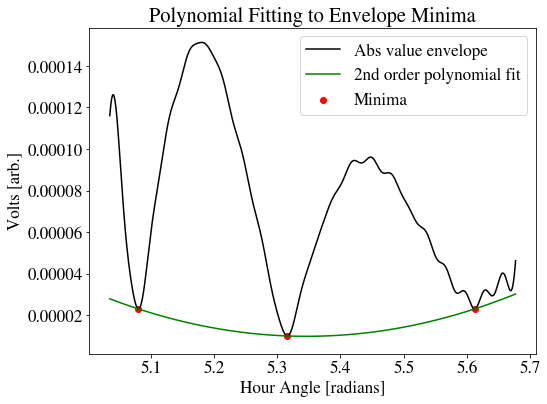

In [359]:
plt.figure(figsize=(8,6))
plt.plot(has, abs_envelope, 'k')
for i in range(len(local_min)):
    plt.scatter(has[local_min[i]], abs_envelope[local_min[i]], color='red')
plt.title('Polynomial Fitting to Envelope Minima')

has_mins = []
envelope_mins = []
for i in range(len(local_min)):
    has_min, envelope_min = has[local_min[i]], abs_envelope[local_min[i]]
    has_mins.append(has_min), envelope_mins.append(envelope_min)
    
poly = np.polyfit(has_mins, envelope_mins, deg=2)
y_poly = np.polyval(poly, has)
plt.plot(has, y_poly, color='g')

plt.legend(labels=['Abs value envelope', '2nd order polynomial fit', 'Minima'])
plt.xlabel('Hour Angle [radians]')
plt.ylabel('Volts [arb.]')
plt.show()

In [365]:
def bessel(ha, θ_R, A):
    λ = 2.77e-2
    delta = 0
    d = 14.7106 #m 14.7106 or 14.8806
    u = d * np.cos(delta) * np.cos(ha) / λ
    x = 2 * np.pi * θ_R * u
    return A * scipy.special.j1(x) / x

In [366]:
p0 = [0.0046, 0.1]
pars, cov = scipy.optimize.curve_fit(bessel, has, envelope, p0)

/home/global/lib/python3.8/site-packages/numpy/lib/function_base.py:601: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


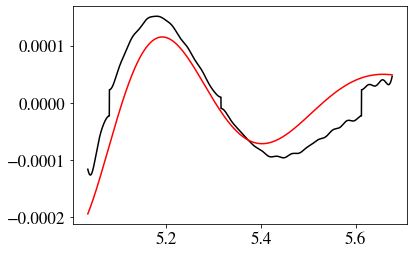

In [372]:
plt.figure()
plt.plot(has, envelope, 'k')
plt.plot(has, bessel(has, *pars), 'r-')
# plt.title('Model Fit to J1(x)/x')
# plt.xlabel('Hour Angle')
# plt.ylabel('Jansky [Arbitrary]')
# plt.legend()

# Sun Data - part 2

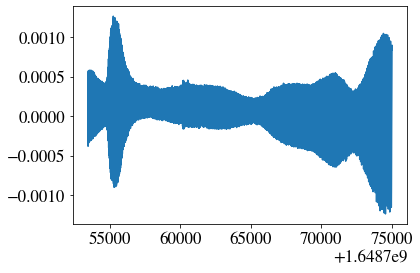

In [374]:
volts, times = np.load('Data/sun_6hr_data_pt2.npy')

plt.plot(times, volts)